<a href="https://colab.research.google.com/github/ArchanaMahto/ClusteringModel/blob/main/Clustering01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 📦 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')


In [ ]:


# Direct CSV file URL or local path if uploaded
csv_url = "/content/Copy of Online Retail.xlsx - Online Retail.csv"
# Load CSV into DataFrame
df = pd.read_csv(csv_url)

# Check the data
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [ ]:
# Remove rows with missing CustomerID & negative quantities (returns)
df.dropna(subset=['CustomerID'], inplace=True)
df = df[df['Quantity'] > 0]

# Create TotalPrice column for total transaction value
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

print("Remaining rows:", df.shape[0])


Remaining rows: 309244


In [ ]:
# Step 1: Convert to datetime first
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Step 2: Create reference date for recency calculation
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Step 3: Proceed with RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.reset_index(inplace=True)


In [ ]:
# Apply StandardScaler to RFM features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


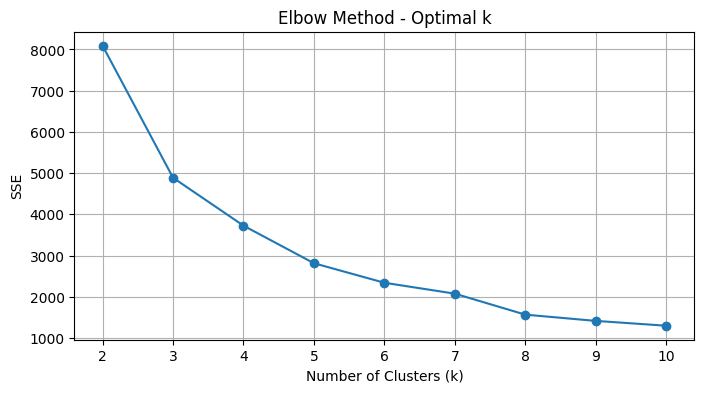

In [ ]:
# Elbow Method
sse = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8,4))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method - Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SSE')
plt.grid(True)
plt.show()


In [ ]:
# Silhouette Scores
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    sil_score = silhouette_score(rfm_scaled, labels)
    print(f'k={k}, Silhouette Score: {sil_score:.4f}')


k=2, Silhouette Score: 0.8922
k=3, Silhouette Score: 0.5579
k=4, Silhouette Score: 0.5823
k=5, Silhouette Score: 0.5650
k=6, Silhouette Score: 0.5026
k=7, Silhouette Score: 0.4840
k=8, Silhouette Score: 0.5034
k=9, Silhouette Score: 0.4412
k=10, Silhouette Score: 0.4474


In [ ]:
# Use final k (e.g., k = 4 based on elbow/silhouette)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

rfm.groupby('Cluster').mean()


,CustomerID,Recency,Frequency,Monetary
Cluster,,,,
0,15154.363636,5.636364,77.090909,110371.321818
1,15257.109453,21.721393,18.885572,10765.291393
2,15255.976789,43.593037,3.280851,1239.281084
3,15353.302632,222.111404,1.510526,468.458571


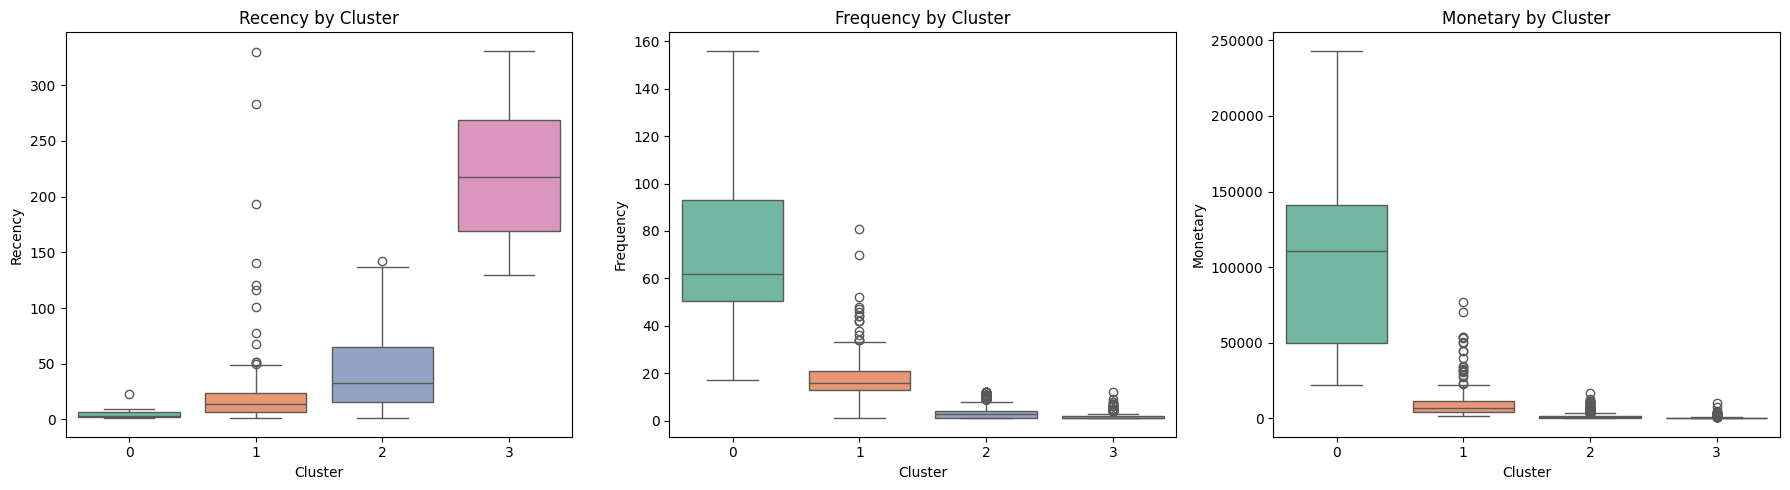

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(data=rfm, x='Cluster', y='Recency', palette='Set2', ax=axes[0])
sns.boxplot(data=rfm, x='Cluster', y='Frequency', palette='Set2', ax=axes[1])
sns.boxplot(data=rfm, x='Cluster', y='Monetary', palette='Set2', ax=axes[2])

axes[0].set_title('Recency by Cluster')
axes[1].set_title('Frequency by Cluster')
axes[2].set_title('Monetary by Cluster')
plt.tight_layout()
plt.show()


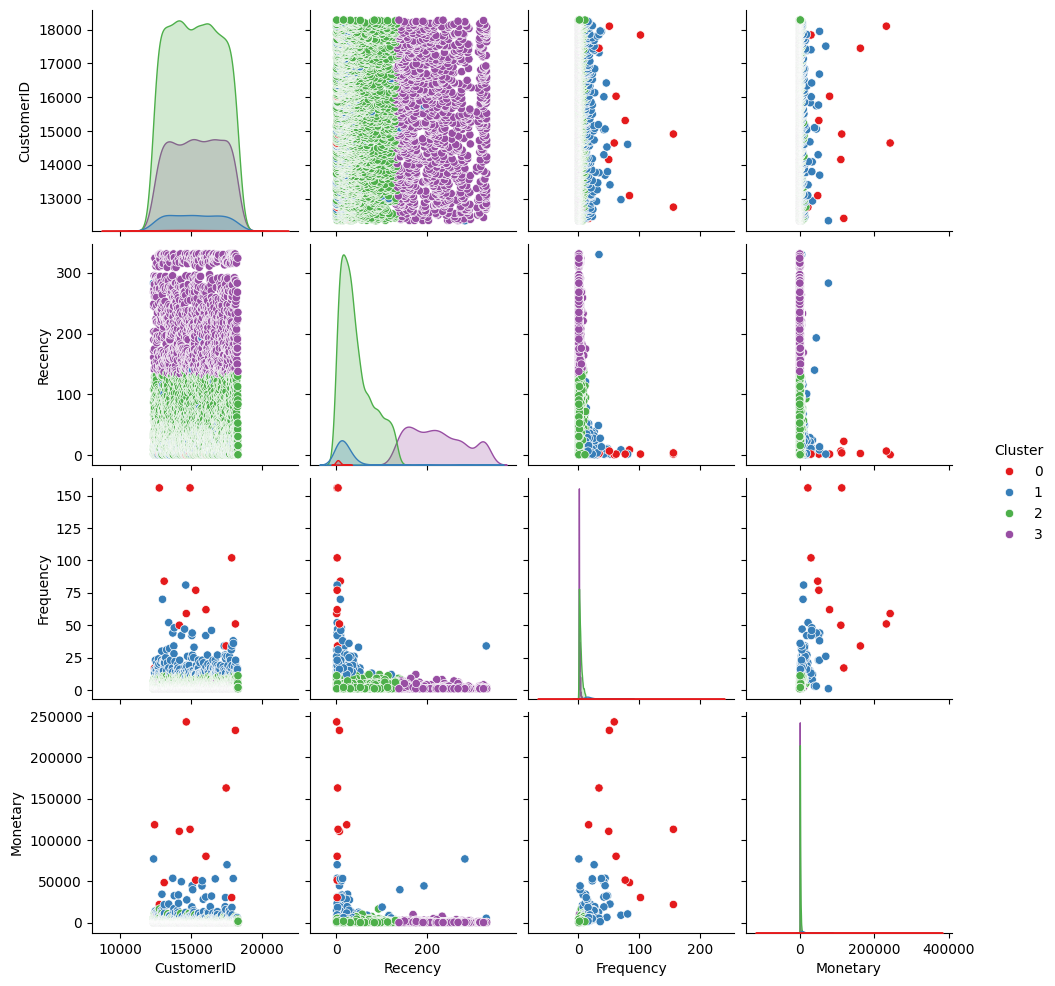

In [ ]:
# Pairplot for overall distribution
sns.pairplot(rfm, hue='Cluster', palette='Set1');


In [ ]:
# Label Interpretation (Custom based on data)
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

cluster_summary.columns = ['Recency', 'Frequency', 'Monetary', 'Count']
cluster_summary


,Recency,Frequency,Monetary,Count
Cluster,,,,
0,5.6,77.1,110371.3,11
1,21.7,18.9,10765.3,201
2,43.6,3.3,1239.3,2585
3,222.1,1.5,468.5,1140
